# U.S. Treasury Yield Curve Forecasting using LSTM


In [1]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from pandas_datareader import data as pdr
from matplotlib import pyplot as plt

## Import data

In [2]:
# Import yield data from the data folder
df = pd.read_csv('../data/yield.csv')
df = df.set_index('DATE')
df.index = pd.to_datetime(df.index)
name = list(df.columns.values)

df

,1MO,3MO,6MO,1YR,2YR,3YR,5YR,7YR,10YR,20YR,30YR
DATE,,,,,,,,,,,
2005-01-03,1.99,2.32,2.63,2.79,3.10,3.28,3.64,3.94,4.23,4.84,4.85
2005-01-04,2.05,2.33,2.63,2.82,3.20,3.38,3.72,4.02,4.29,4.91,4.91
2005-01-05,2.04,2.33,2.63,2.83,3.22,3.39,3.73,4.02,4.29,4.88,4.88
2005-01-06,2.04,2.31,2.63,2.82,3.18,3.36,3.71,4.01,4.29,4.88,4.89
2005-01-07,2.03,2.32,2.63,2.82,3.20,3.40,3.73,4.03,4.29,4.88,4.88
...,...,...,...,...,...,...,...,...,...,...,...
2025-09-03,4.35,4.18,3.96,3.77,3.61,3.58,3.69,3.92,4.22,4.85,4.90
2025-09-04,4.33,4.16,3.94,3.76,3.59,3.55,3.65,3.87,4.17,4.81,4.86
2025-09-05,4.29,4.07,3.85,3.65,3.51,3.48,3.59,3.80,4.10,4.72,4.78


In [3]:
# Split into training 85%/ validation 10% / testing 5% 
n_train_end = int(len(df[:-756])*0.8)
n_valid_end = -756
df_train = df.iloc[:n_train_end]
df_valid = df.iloc[n_train_end:n_valid_end]
df_test = df.iloc[n_valid_end:]

## LSTM

### Data preprocessing

In [4]:
# Preprocess score data
scaler = StandardScaler()
scaler.fit(df_train)
scaled_data = scaler.transform(df)
scaled_data_train = scaler.transform(df_train)

# Prepare LSTM input
horizons = [21, 63, 126, 252]

def create_LSTM_input(data, lag, horizon):
    X, Y = [], []
    for i in range(len(data) - lag - horizon + 1):
        X.append(data[i:i+lag])
        Y.append(data[i+lag+horizon-1])
    X_tensor = torch.tensor(np.array(X), dtype=torch.float32)
    Y_tensor = torch.tensor(np.array(Y), dtype=torch.float32)
    return X_tensor, Y_tensor

lag = 20

Xtr, Ytr = create_LSTM_input(scaled_data_train, lag, 1)
Xv, Yv = create_LSTM_input(scaled_data[n_train_end - lag : n_valid_end], lag, 1)
Xte, Yte = [], []
for h in horizons:
    LSTM_input = create_LSTM_input(scaled_data[n_valid_end - lag - h + 1:], lag, h)
    Xte.append(LSTM_input[0])
    Yte.append(LSTM_input[1])
#Xte, Yte = create_LSTM_input(scaled_data[n_valid_end - lag:], lag)

# Wrap the data in torch TensorDataset, DataLoader
dataset = TensorDataset(Xtr, Ytr)
loader = DataLoader(dataset, batch_size=32, shuffle=True)


### Construct LSTM model

In [5]:
# Construct LSTM model

class LSTM(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, num_layers=2, dropout=0.2):
        super().__init__()
        self.lstm = nn.LSTM(input_dim, 
                            hidden_dim, 
                            num_layers,
                            dropout = dropout,
                            batch_first=True)
        self.linear = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        out, _ = self.lstm(x)               # out: (batch, seq_len, hidden_dim)
        out = out[:, -1, :]                 # use last output for forecasting
        out = self.linear(out)              # project to output dimension
        return out

model = LSTM(input_dim=11, hidden_dim=128, output_dim=11)

loss_func = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)
epochs = 10

### Train model

In [8]:
# Train LSTM model
model.train()
for epoch in range(epochs):
    for xb, yb in loader:
        pred = model(xb)
        loss = loss_func(pred, yb)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    if epoch % 1 == 0:
        print(f"Epoch {epoch}: loss = {loss.item():.4f}")

Epoch 0: loss = 0.0072
Epoch 1: loss = 0.0138
Epoch 2: loss = 0.0063
Epoch 3: loss = 0.0068
Epoch 4: loss = 0.0097
Epoch 5: loss = 0.0050
Epoch 6: loss = 0.0083
Epoch 7: loss = 0.0092
Epoch 8: loss = 0.0065
Epoch 9: loss = 0.0061


In [9]:
# Validation
model.eval()
train_loss = loss_func(model(Xtr), Ytr)
val_loss = loss_func(model(Xv), Yv)
print(f'Train loss      : {train_loss}')
print(f'Validation loss : {val_loss}')

Train loss      : 0.00638221763074398
Validation loss : 0.04161050543189049


In [11]:
# Forecast
model.eval()
yield_fore = []
horizon_month = [1,3,6,12]

with torch.no_grad():
    for i in range(4):
        fore = []
        for x in Xte[i]:
            x = x.unsqueeze(0)
            #print(x)
            for _ in range(horizons[i]):      # Rolling forecast
                y = model(x)
                y = y.unsqueeze(0)
                x = torch.cat((x,y), dim=1)[:,1:,:]
                #print(x)
            forecast = scaler.inverse_transform(y.squeeze(0).numpy())
            fore.append(forecast[0])

        res = pd.DataFrame(np.array(fore), columns=df.columns, index=df_test.index)
        res.to_csv(f'../results/LSTM_fore_{horizon_month[i]}.csv', index=False)
        yield_fore.append(res)
        
yield_fore[0]

,1MO,3MO,6MO,1YR,2YR,3YR,5YR,7YR,10YR,20YR,30YR
DATE,,,,,,,,,,,
2022-08-30,2.335304,2.453113,2.602933,2.775037,2.938334,2.932465,2.940141,2.956632,3.002724,3.032744,3.089862
2022-08-31,2.345558,2.463004,2.612613,2.784993,2.948706,2.941332,2.946520,2.961416,3.006866,3.034835,3.090552
2022-09-01,2.356523,2.473383,2.622694,2.795462,2.959725,2.950409,2.952853,2.965775,3.010439,3.035851,3.090226
2022-09-02,2.355699,2.471979,2.621060,2.794097,2.958559,2.948424,2.950835,2.963118,3.007540,3.032013,3.086998
2022-09-06,2.398079,2.514801,2.663626,2.836797,3.002140,2.988636,2.981533,2.989860,3.032645,3.052350,3.100040
...,...,...,...,...,...,...,...,...,...,...,...
2025-09-03,3.258719,3.364393,3.565590,3.486013,3.337097,3.401944,3.598590,3.835096,4.099019,4.615150,4.612046
2025-09-04,3.236115,3.341783,3.542163,3.465658,3.320468,3.386828,3.585497,3.821641,4.086813,4.604559,4.600192
2025-09-05,3.215301,3.320858,3.521152,3.447189,3.305097,3.373163,3.574354,3.810826,4.077820,4.597845,4.592798


In [12]:
# RMSE table

def RMSE_table(yield_fores):
    RMSE = []
    for yield_fore in yield_fores:
        RMSE.append(np.sqrt(np.mean((yield_fore.to_numpy() - df_test.to_numpy())**2, axis=0)))
    RMSE = np.array(RMSE)
    ind = ['1', '3', '6', '12']
    return pd.DataFrame(RMSE, columns=df.columns, index=ind)

# Save results
RMSE_table(yield_fore).to_csv('../results/LSTM_RMSE.csv', index=False)
RMSE_table(yield_fore)

,1MO,3MO,6MO,1YR,2YR,3YR,5YR,7YR,10YR,20YR,30YR
1,0.481046,0.416065,0.370528,0.397753,0.446060,0.535322,0.565856,0.563579,0.569643,0.465706,0.428430
3,0.542557,0.555346,0.618323,0.688291,0.764825,0.841034,0.898065,0.833881,0.824962,0.750000,0.700214
6,0.797851,0.876239,0.984695,1.036494,1.031864,1.063267,1.048855,0.933916,0.882661,0.791144,0.701764
12,1.933729,2.063355,2.145936,2.109374,1.911071,1.797338,1.538759,1.283124,1.023787,0.841587,0.643220


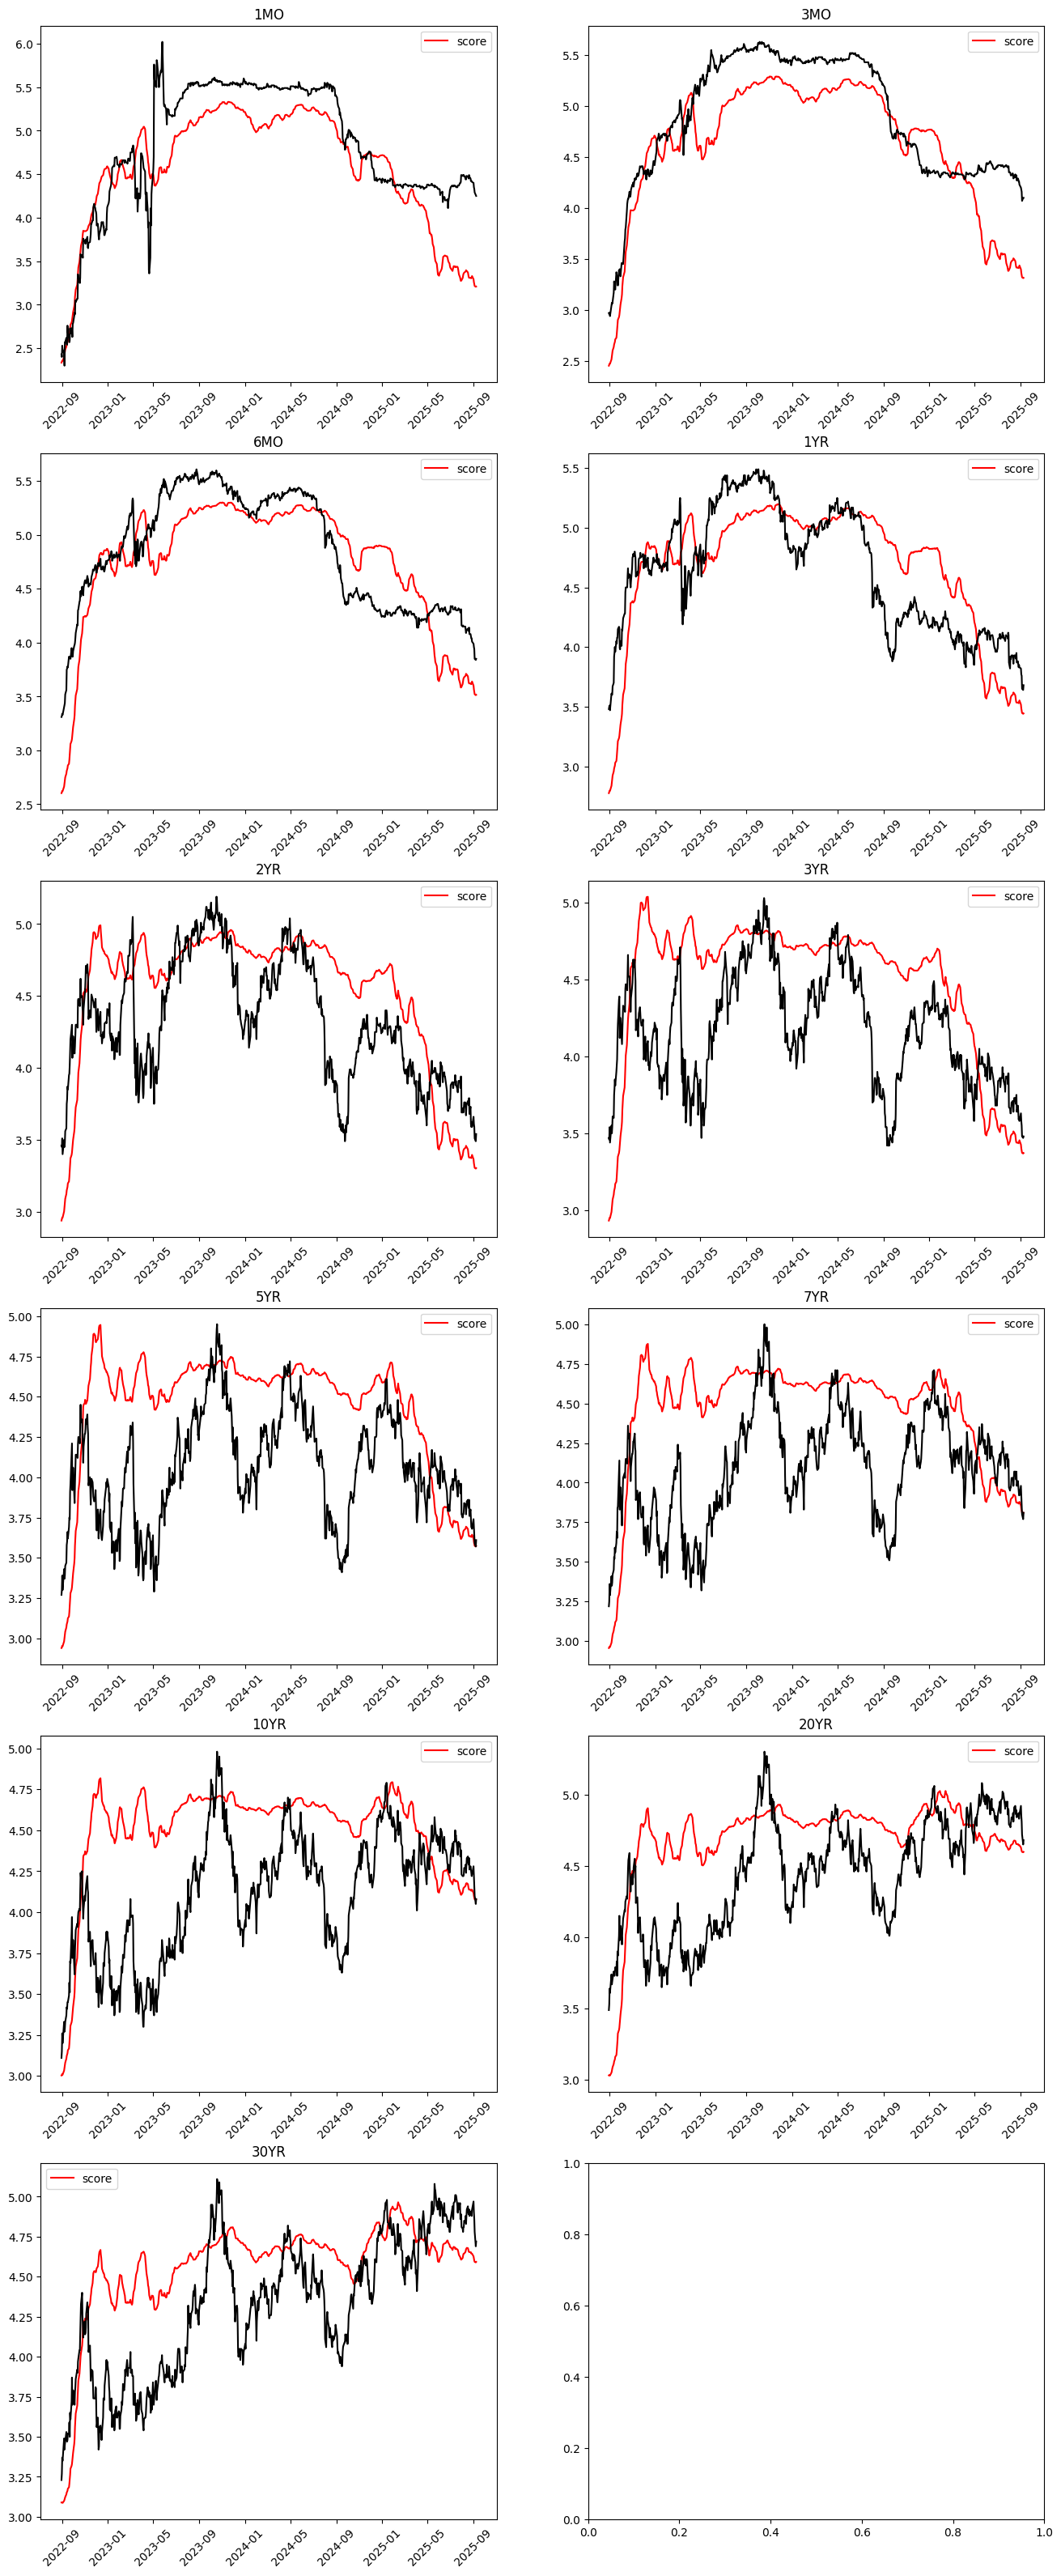

In [13]:
# Plot the forecasted (1 month ahead) vs actual yield
fig, ax = plt.subplots(6,2,figsize=(16,40))

for i in range(6):
    for j in range(2):
        ind = 2*i+j
        if ind == len(name): break
        ax[i, j].plot(yield_fore[0][name[ind]], color='red', label='score')
        ax[i, j].plot(df_test[name[ind]], color='black')
        ax[i, j].legend()
        ax[i, j].tick_params('x', labelrotation=45)
        ax[i, j].set_title(name[ind])